## Overview
___

## Business Problem
___

## Data Understanding
___

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import layers, models, regularizers
from tensorflow.keras.applications import Xception
from tensorflow import keras

import PIL
import os
import cv2 as cv

from sklearn.metrics import classification_report

In [2]:
import winsound
duration = 1000  # milliseconds
freq = 440  # Hz
winsound.Beep(freq, duration)

In [3]:
# Identify data directories
data_train ='chest_xray/train'
data_test = 'chest_xray/test'
data_val = 'chest_xray/val'

In [4]:
# Get the size of each image in the data set
image = PIL.Image.open("IM-0115-0001.jpeg")
width, height = image.size
print('Image Size:', width, 'x', height)
target_size = (width, height)

Image Size: 2090 x 1858


In [5]:
test_norm =  [file for file in os.listdir('chest_xray/test/NORMAL') if file.endswith('jpeg')]
test_pnem =  [file for file in os.listdir('chest_xray/test/PNEUMONIA') if file.endswith('jpeg')]
print('Number of test images (normal):', len(test_norm))
print('Number of test images (pnemonia):', len(test_pnem))
print('Percentage of test images pnemonia:', len(test_pnem)/(len(test_norm)+len(test_pnem)))

val_norm =  [file for file in os.listdir('chest_xray/val/NORMAL') if file.endswith('jpeg')]
val_pnem =  [file for file in os.listdir('chest_xray/val/PNEUMONIA') if file.endswith('jpeg')]
print('Number of validation images (normal):', len(val_norm))
print('Number of validation images (pnemonia):', len(val_pnem))

Number of test images (normal): 203
Number of test images (pnemonia): 337
Percentage of test images pnemonia: 0.6240740740740741
Number of validation images (normal): 39
Number of validation images (pnemonia): 61


In [6]:
train_norm =  [file for file in os.listdir('chest_xray/train/NORMAL') if file.endswith('jpeg')]
train_pnem =  [file for file in os.listdir('chest_xray/train/PNEUMONIA') if file.endswith('jpeg')]
print('Number of train images (normal):', len(train_norm))
print('Number of train images (pnemonia):', len(train_pnem))
print('Percentage of test images pnemonia:', len(train_pnem)/(len(train_pnem)+len(train_norm)))

Number of train images (normal): 1341
Number of train images (pnemonia): 3875
Percentage of test images pnemonia: 0.7429064417177914


Only 16 images are included in the validation data. That's really not enough images to confidently evaluate the model and tweak accordingly.  What we'll do is move 84 images from the testing set to the validation set to round out the validation set at 100 images which should give us more confidence evaluating the model. I'll move 31 normal images and 53 pnemonia images from the testing set to the validation set to maintain the same percentage of pnemonia images in the testing set (62.5%).

In [6]:
# Get first 31 test normal images, and 53 test pnemonia images
test_normal_31 = test_norm[:31]
test_pnemonia_53 = test_pnem[:53]

# Move these image from their testing folders to the respective validation folders
for file in test_normal_31:
    os.replace('chest_xray/test/NORMAL/{}'.format(file), 'chest_xray/val/NORMAL/{}'.format(file))
for file in test_pnemonia_53:
    os.replace('chest_xray/test/PNEUMONIA/{}'.format(file), 'chest_xray/val/PNEUMONIA/{}'.format(file))

In [5]:
test_norm_revised =  [file for file in os.listdir('chest_xray/test/NORMAL') if file.endswith('jpeg')]
test_pnem_revised =  [file for file in os.listdir('chest_xray/test/PNEUMONIA') if file.endswith('jpeg')]
print('Number of test images (normal):', len(test_norm_revised))
print('Number of test images (pnemonia):', len(test_pnem_revised))
print('Percentage of test images pnemonia:', len(test_pnem_revised)/(len(test_norm_revised)+len(test_pnem_revised)))

val_norm_revised =  [file for file in os.listdir('chest_xray/val/NORMAL') if file.endswith('jpeg')]
val_pnem_revised =  [file for file in os.listdir('chest_xray/val/PNEUMONIA') if file.endswith('jpeg')]
print('Number of validation images (normal):', len(val_norm_revised))
print('Number of validation images (pnemonia):', len(val_pnem_revised))

Number of test images (normal): 203
Number of test images (pnemonia): 337
Percentage of test images pnemonia: 0.6240740740740741
Number of validation images (normal): 39
Number of validation images (pnemonia): 61


In [13]:
# Reverse the above code
for file in test_normal_31:
    os.replace('chest_xray/val/NORMAL/{}'.format(file), 'chest_xray/test/NORMAL/{}'.format(file))
for file in test_pnemonia_53:
    os.replace('chest_xray/val/PNEUMONIA/{}'.format(file), 'chest_xray/test/PNEUMONIA/{}'.format(file))

Create imagedatagenerator objects for the 

In [11]:
# get all the data in the directory split/test, and reshape them
train_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_train,
        target_size=(128, 128),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary') 

# get all the data in the directory split/validation (200 images), and reshape them
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_test,
        target_size=(128, 128),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary') 

# get all the data in the directory split/train (542 images), and reshape them
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_val,
        target_size=(128, 128),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary') 

Found 5216 images belonging to 2 classes.
Found 540 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


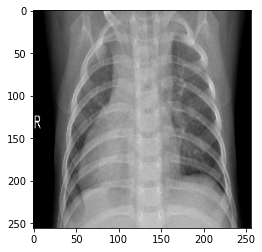

In [112]:
plt.imshow(train_images[0], cmap='gray')

Start with one layer CNN (with dense layer for classification)

Then do can modify:
* input_size
* batch_size
* regularization
* optimizers
* learning_rate (adams optimizer)


In [7]:
def visualize_training_results(results):
    history=results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [8]:
def get_report(model):
    preds = model.predict(test_gen)
    preds[preds <= 0.5] = 0
    preds[preds > 0.5] = 1
    print(classification_report(test_gen.labels, preds,
                                target_names=["normal", "pneumonia"]))

Baseline CCN model with a single convolutional layer

In [133]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3,), activation='relu', input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(),
              metrics=['acc'])

In [134]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 127008)            0         
_________________________________________________________________
dense_24 (Dense)             (None, 512)               65028608  
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 513       
Total params: 65,029,441
Trainable params: 65,029,441
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
261/261 [==============================] - 120s 461ms/step - loss: 0.0868 - acc: 0.9672 - val_loss: 0.7863 - val_acc: 0.7100
Epoch 2/20
261/261 [==============================] - 116s 442ms/step - loss: 0.0433 - acc: 0.9845 - val_loss: 1.3829 - val_acc: 0.6900
Epoch 3/20
261/261 [==============================] - 117s 450ms/step - loss: 0.0215 - acc: 0.9931 - val_loss: 1.0280 - val_acc: 0.7100
Epoch 4/20
261/261 [==============================] - 111s 427ms/step - loss: 0.0133 - acc: 0.9962 - val_loss: 1.2310 - val_acc: 0.7300
Epoch 5/20
261/261 [==============================] - 113s 431ms/step - loss: 0.0051 - acc: 0.9992 - val_loss: 1.0744 - val_acc: 0.7600
Epoch 6/20
261/261 [==============================] - 114s 436ms/step - loss: 0.0025 - acc: 0.9998 - val_loss: 1.6845 - val_acc: 0.7200
Epoch 7/20
261/261 [==============================] - 113s 434ms/step - loss: 9.2265e-04 - acc: 1.0000 - val_loss: 1.5601 - val_acc: 0.7200
Epoch 8/20
261/261 [========================

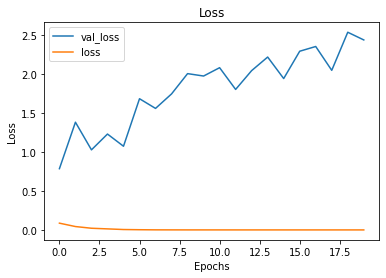

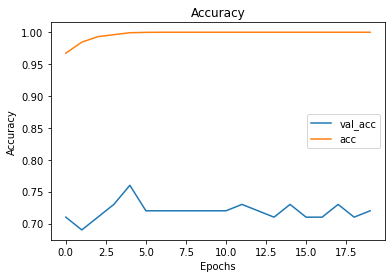

INFO:tensorflow:Assets written to: models/model_0\assets


In [139]:
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=20)
get_report(model)
visualize_training_results(history)
model.save('models/model_0')

In [154]:
get_report(model)

              precision    recall  f1-score   support

      normal       0.43      0.13      0.20       203
   pneumonia       0.63      0.90      0.74       337

    accuracy                           0.61       540
   macro avg       0.53      0.51      0.47       540
weighted avg       0.55      0.61      0.54       540



Test_accuracy was about 73.15% 

For the next model:
* Decrease the Conv2D layer from 32 to 16 nodes
* Decrease the first Dense layer from 512 to 100 nodes.

Epoch 1/10
261/261 [==============================] - 68s 259ms/step - loss: 0.2173 - acc: 0.9174 - val_loss: 0.9563 - val_acc: 0.6400
Epoch 2/10
261/261 [==============================] - 63s 242ms/step - loss: 0.0883 - acc: 0.9672 - val_loss: 0.6904 - val_acc: 0.7100
Epoch 3/10
261/261 [==============================] - 61s 235ms/step - loss: 0.0531 - acc: 0.9820 - val_loss: 1.2218 - val_acc: 0.6700
Epoch 4/10
261/261 [==============================] - 64s 244ms/step - loss: 0.0440 - acc: 0.9856 - val_loss: 1.5311 - val_acc: 0.6500
Epoch 5/10
261/261 [==============================] - 59s 225ms/step - loss: 0.0270 - acc: 0.9919 - val_loss: 0.8016 - val_acc: 0.7600
Epoch 6/10
261/261 [==============================] - 56s 216ms/step - loss: 0.0208 - acc: 0.9941 - val_loss: 1.3788 - val_acc: 0.7100
Epoch 7/10
261/261 [==============================] - 61s 234ms/step - loss: 0.0148 - acc: 0.9964 - val_loss: 0.8501 - val_acc: 0.7600
Epoch 8/10
261/261 [==============================] - 6

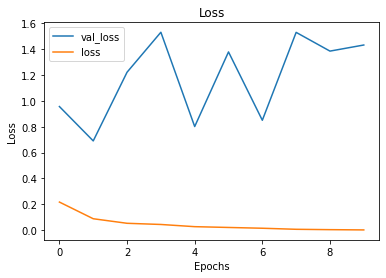

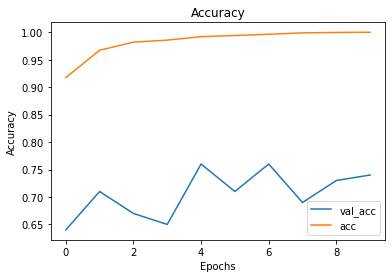

INFO:tensorflow:Assets written to: models/model_1\assets


In [159]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(),
              metrics=['acc'])
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=10)
get_report(model)
visualize_training_results(history)
model.save('models/model_1')

Accuracy decreased from Model_0, the accuracy is still bouncing around all over the place.

Model_2:
* same neural network
* set the optimizer to Adam and the learning rate to 0.001
* decrease epochs from 10 to 5

Epoch 1/5
261/261 [==============================] - 58s 222ms/step - loss: 0.3165 - acc: 0.9086 - val_loss: 1.8979 - val_acc: 0.6200
Epoch 2/5
261/261 [==============================] - 64s 245ms/step - loss: 0.0965 - acc: 0.9638 - val_loss: 1.0358 - val_acc: 0.6700
Epoch 3/5
261/261 [==============================] - 62s 237ms/step - loss: 0.0513 - acc: 0.9816 - val_loss: 1.8587 - val_acc: 0.6400
Epoch 4/5
261/261 [==============================] - 62s 238ms/step - loss: 0.0295 - acc: 0.9919 - val_loss: 0.6326 - val_acc: 0.7800
Epoch 5/5
261/261 [==============================] - 57s 220ms/step - loss: 0.0231 - acc: 0.9919 - val_loss: 0.5180 - val_acc: 0.8300
              precision    recall  f1-score   support

      normal       0.36      0.18      0.24       203
   pneumonia       0.62      0.80      0.70       337

    accuracy                           0.57       540
   macro avg       0.49      0.49      0.47       540
weighted avg       0.52      0.57      0.53       540



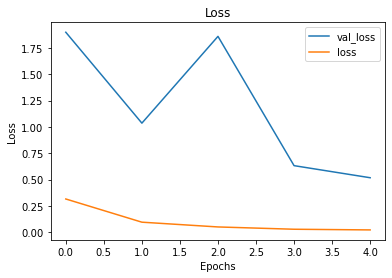

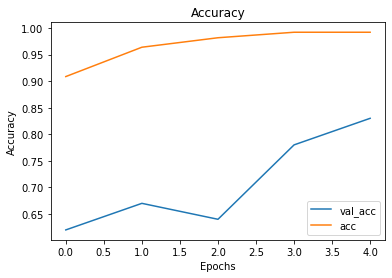

INFO:tensorflow:Assets written to: models/model_2\assets


In [160]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=.001),
              metrics=['acc'])
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=5)
get_report(model)
visualize_training_results(history)
model.save('models/model_2')

The accuracy seems to stop jumping around so much. With the test accuracy increasing as epochs go on, it seems the model might be underfit.

Model_3:
* Decrease Conv2D nodes from 16 to 8

Epoch 1/5
261/261 [==============================] - 55s 209ms/step - loss: 0.4017 - acc: 0.8390 - val_loss: 0.2527 - val_acc: 0.8800
Epoch 2/5
261/261 [==============================] - 53s 205ms/step - loss: 0.1649 - acc: 0.9369 - val_loss: 0.4358 - val_acc: 0.7900
Epoch 3/5
261/261 [==============================] - 56s 214ms/step - loss: 0.1238 - acc: 0.9519 - val_loss: 1.0545 - val_acc: 0.6600
Epoch 4/5
261/261 [==============================] - 55s 209ms/step - loss: 0.1123 - acc: 0.9588 - val_loss: 0.5287 - val_acc: 0.7600
Epoch 5/5
261/261 [==============================] - 52s 199ms/step - loss: 0.1023 - acc: 0.9613 - val_loss: 0.6727 - val_acc: 0.7300
              precision    recall  f1-score   support

      normal       0.33      0.15      0.20       203
   pneumonia       0.62      0.82      0.70       337

    accuracy                           0.57       540
   macro avg       0.47      0.48      0.45       540
weighted avg       0.51      0.57      0.52       540



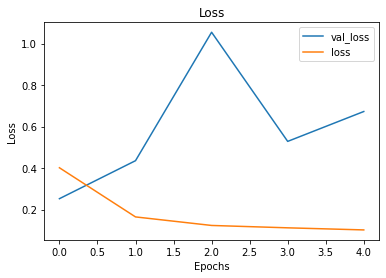

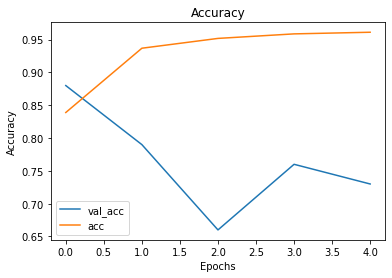

INFO:tensorflow:Assets written to: models/model_3\assets


In [161]:
model = models.Sequential()
model.add(layers.Conv2D(8, (3,3,), activation='relu', input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=.001),
              metrics=['acc'])
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=5)
get_report(model)
visualize_training_results(history)
model.save('models/model_3')

Accuracy now seems to decrease over the epochs, seems that we are overfitting.

Model_4:
* Increase Conv2D nodes to 32
* Change learning rate from 0.001 to 0.0001

Epoch 1/5
261/261 [==============================] - 77s 292ms/step - loss: 0.2894 - acc: 0.8806 - val_loss: 0.3774 - val_acc: 0.7800
Epoch 2/5
261/261 [==============================] - 72s 276ms/step - loss: 0.1286 - acc: 0.9511 - val_loss: 0.4486 - val_acc: 0.7900
Epoch 3/5
261/261 [==============================] - 72s 274ms/step - loss: 0.1020 - acc: 0.9643 - val_loss: 0.2580 - val_acc: 0.8700
Epoch 4/5
261/261 [==============================] - 70s 269ms/step - loss: 0.0881 - acc: 0.9701 - val_loss: 0.5655 - val_acc: 0.7300
Epoch 5/5
261/261 [==============================] - 66s 251ms/step - loss: 0.0831 - acc: 0.9705 - val_loss: 0.2718 - val_acc: 0.8500
              precision    recall  f1-score   support

      normal       0.40      0.26      0.31       203
   pneumonia       0.63      0.77      0.69       337

    accuracy                           0.57       540
   macro avg       0.51      0.51      0.50       540
weighted avg       0.54      0.57      0.55       540



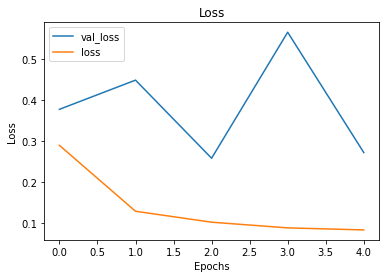

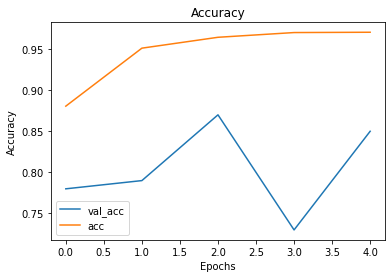

INFO:tensorflow:Assets written to: models/model_4\assets


In [164]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3,), activation='relu', input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=.0001),
              metrics=['acc'])
history = model.fit(train_gen,
                  validation_data=val_gen,
                  epochs=5)
get_report(model)
visualize_training_results(history)
model.save('models/model_4')

Test accuracy seems to be getting better training over more epochs, not overfitting yet. 

Model_5:
* add a second Conv2D Layer with 32 nodes.

Epoch 1/5
261/261 [==============================] - 69s 262ms/step - loss: 0.3241 - acc: 0.8645 - val_loss: 0.7737 - val_acc: 0.6400
Epoch 2/5
261/261 [==============================] - 77s 297ms/step - loss: 0.1301 - acc: 0.9519 - val_loss: 0.5456 - val_acc: 0.7400
Epoch 3/5
261/261 [==============================] - 78s 297ms/step - loss: 0.0991 - acc: 0.9636 - val_loss: 0.3747 - val_acc: 0.8400
Epoch 4/5
261/261 [==============================] - 72s 276ms/step - loss: 0.0915 - acc: 0.9653 - val_loss: 1.0239 - val_acc: 0.6600
Epoch 5/5
261/261 [==============================] - 72s 275ms/step - loss: 0.0831 - acc: 0.9707 - val_loss: 0.4342 - val_acc: 0.8200
              precision    recall  f1-score   support

      normal       0.38      0.20      0.26       203
   pneumonia       0.63      0.81      0.71       337

    accuracy                           0.58       540
   macro avg       0.51      0.50      0.48       540
weighted avg       0.54      0.58      0.54       540



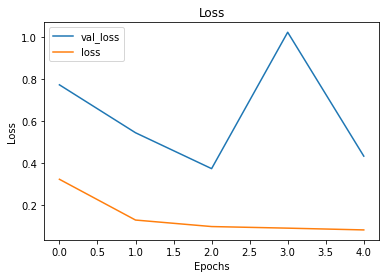

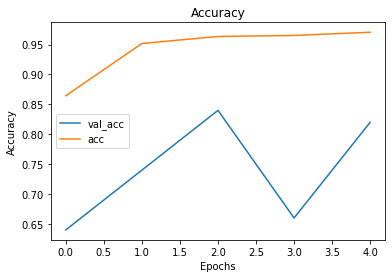

INFO:tensorflow:Assets written to: models/model_5\assets


In [165]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3,), activation='relu', input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())

model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=.0001),
              metrics=['acc'])
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=5)
get_report(model)
visualize_training_results(history)
model.save('models/model_5')

Still underfitting due to increasing test accuracy.

Model_6:
* Add another Conv2D layer.
* Change Conv2D Layer nodes to increase as progress through network
* Change Dense output layer to 512 nodes

Epoch 1/5
261/261 [==============================] - 81s 311ms/step - loss: 0.3481 - acc: 0.8520 - val_loss: 0.2853 - val_acc: 0.8700
Epoch 2/5
261/261 [==============================] - 79s 303ms/step - loss: 0.1228 - acc: 0.9569 - val_loss: 0.6266 - val_acc: 0.7300
Epoch 3/5
261/261 [==============================] - 81s 311ms/step - loss: 0.1039 - acc: 0.9572 - val_loss: 0.6063 - val_acc: 0.7500
Epoch 4/5
261/261 [==============================] - 73s 281ms/step - loss: 0.0845 - acc: 0.9691 - val_loss: 0.6974 - val_acc: 0.7100
Epoch 5/5
261/261 [==============================] - 105s 404ms/step - loss: 0.0802 - acc: 0.9712 - val_loss: 0.3724 - val_acc: 0.8500
              precision    recall  f1-score   support

      normal       0.43      0.19      0.27       203
   pneumonia       0.63      0.85      0.73       337

    accuracy                           0.60       540
   macro avg       0.53      0.52      0.50       540
weighted avg       0.56      0.60      0.55       540



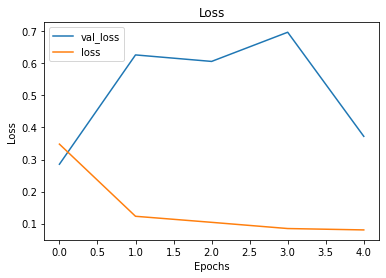

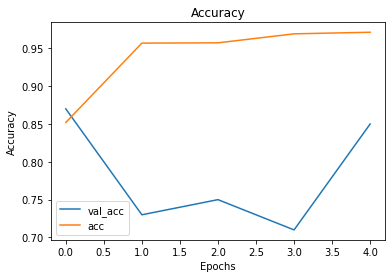

INFO:tensorflow:Assets written to: models/model_6\assets


In [166]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=.0001),
              metrics=['acc'])
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=5)
get_report(model)
visualize_training_results(history)
model.save('models/model_6')

Test accuracy is bouncing all over the place but increasing as we refine the model.

Model_7:
* Decrease learning rate from 0.0001 to 0.00001
* Train over 10 epochs (up from 5 epochs)

Epoch 1/10
261/261 [==============================] - 97s 370ms/step - loss: 0.5387 - acc: 0.7437 - val_loss: 0.6185 - val_acc: 0.6100
Epoch 2/10
261/261 [==============================] - 83s 318ms/step - loss: 0.3848 - acc: 0.8299 - val_loss: 0.4608 - val_acc: 0.7000
Epoch 3/10
261/261 [==============================] - 75s 288ms/step - loss: 0.2606 - acc: 0.9105 - val_loss: 0.4441 - val_acc: 0.7100
Epoch 4/10
261/261 [==============================] - 75s 287ms/step - loss: 0.2017 - acc: 0.9308 - val_loss: 0.4609 - val_acc: 0.7100
Epoch 5/10
261/261 [==============================] - 79s 303ms/step - loss: 0.1660 - acc: 0.9446 - val_loss: 0.3784 - val_acc: 0.7800
Epoch 6/10
261/261 [==============================] - 73s 278ms/step - loss: 0.1401 - acc: 0.9549 - val_loss: 0.3920 - val_acc: 0.8000
Epoch 7/10
261/261 [==============================] - 66s 252ms/step - loss: 0.1226 - acc: 0.9586 - val_loss: 0.3429 - val_acc: 0.8000
Epoch 8/10
261/261 [==============================] - 7

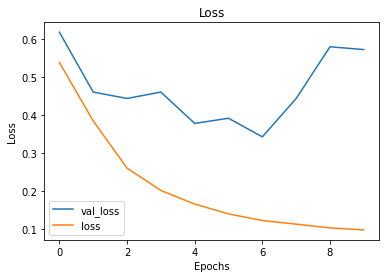

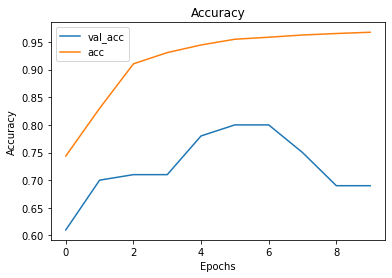

INFO:tensorflow:Assets written to: models/model_7\assets


In [13]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=.00001),
              metrics=['acc'])
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=10)
get_report(model)
visualize_training_results(history)
model.save('models/model_7')

Test accuracy seems to be increasing more steadily now.

Rerun Model_7
* Increase the batch_size from 20 to 50

In [14]:
# get all the data in the directory split/test, and reshape them
train_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_train,
        target_size=(128, 128),
        color_mode='grayscale',
        batch_size=50,
        class_mode='binary') 

# get all the data in the directory split/validation (200 images), and reshape them
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_test,
        target_size=(128, 128),
        color_mode='grayscale',
        batch_size=50,
        class_mode='binary') 

# get all the data in the directory split/train (542 images), and reshape them
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_val,
        target_size=(128, 128),
        color_mode='grayscale',
        batch_size=50,
        class_mode='binary') 

Found 5216 images belonging to 2 classes.
Found 540 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


Epoch 1/10
105/105 [==============================] - 64s 602ms/step - loss: 0.5744 - acc: 0.7429 - val_loss: 0.6984 - val_acc: 0.6100
Epoch 2/10
105/105 [==============================] - 78s 744ms/step - loss: 0.5171 - acc: 0.7429 - val_loss: 0.6355 - val_acc: 0.6100
Epoch 3/10
105/105 [==============================] - 72s 688ms/step - loss: 0.4487 - acc: 0.7657 - val_loss: 0.5358 - val_acc: 0.6300
Epoch 4/10
105/105 [==============================] - 61s 578ms/step - loss: 0.3764 - acc: 0.8464 - val_loss: 0.4731 - val_acc: 0.7200
Epoch 5/10
105/105 [==============================] - 66s 634ms/step - loss: 0.3174 - acc: 0.8884 - val_loss: 0.4514 - val_acc: 0.7400
Epoch 6/10
105/105 [==============================] - 66s 630ms/step - loss: 0.2729 - acc: 0.9130 - val_loss: 0.3744 - val_acc: 0.8100
Epoch 7/10
105/105 [==============================] - 60s 571ms/step - loss: 0.2364 - acc: 0.9241 - val_loss: 0.4296 - val_acc: 0.7500
Epoch 8/10
105/105 [==============================] - 6

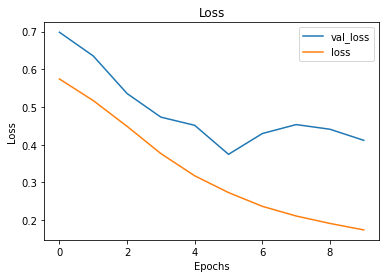

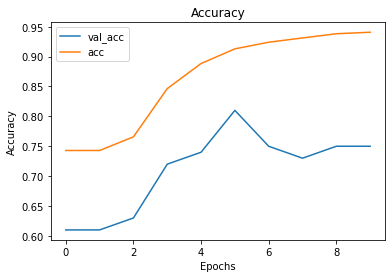

INFO:tensorflow:Assets written to: models/model_7\assets


In [15]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=.00001),
              metrics=['acc'])
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=10)
get_report(model)
visualize_training_results(history)
model.save('models/model_7')

Test accuracy seems to improve over when the batch_size was 20.

model_7_1:
* add rotation_range of 15 degrees 

In [16]:
# get all the data in the directory split/test, and reshape them
train_gen = ImageDataGenerator(rescale=1./255,
                              rotation_range=15, 
                               fill_mode='nearest'
                              ).flow_from_directory(
        data_train,
        target_size=(128, 128),
        color_mode='grayscale',
        batch_size=50,
        class_mode='binary') 

Found 5216 images belonging to 2 classes.


Epoch 1/10
105/105 [==============================] - 61s 582ms/step - loss: 0.5773 - acc: 0.7372 - val_loss: 0.6604 - val_acc: 0.6100
Epoch 2/10
105/105 [==============================] - 72s 689ms/step - loss: 0.5188 - acc: 0.7431 - val_loss: 0.6281 - val_acc: 0.6100
Epoch 3/10
105/105 [==============================] - 80s 765ms/step - loss: 0.4492 - acc: 0.7640 - val_loss: 0.5327 - val_acc: 0.6400
Epoch 4/10
105/105 [==============================] - 72s 682ms/step - loss: 0.3725 - acc: 0.8438 - val_loss: 0.4761 - val_acc: 0.6900
Epoch 5/10
105/105 [==============================] - 71s 679ms/step - loss: 0.3164 - acc: 0.8832 - val_loss: 0.3847 - val_acc: 0.8400
Epoch 6/10
105/105 [==============================] - 71s 672ms/step - loss: 0.2775 - acc: 0.8982 - val_loss: 0.3769 - val_acc: 0.8200
Epoch 7/10
105/105 [==============================] - 65s 619ms/step - loss: 0.2473 - acc: 0.9109 - val_loss: 0.3422 - val_acc: 0.8500
Epoch 8/10
105/105 [==============================] - 6

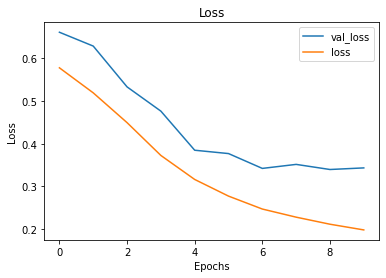

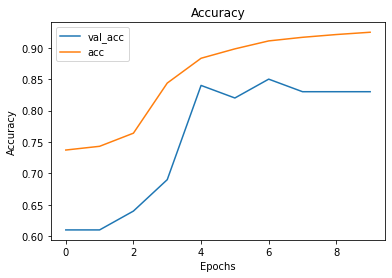

INFO:tensorflow:Assets written to: models/model_7_1\assets


In [17]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=.00001),
              metrics=['acc'])
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=10)
get_report(model)
visualize_training_results(history)
winsound.Beep(freq, duration)
model.save('models/model_7_1')

Testing accuracy seems to be increasing with number of epochs.

Model_7_2:
* add width and height shifts

In [18]:
# get all the data in the directory split/test, and reshape them
train_gen = ImageDataGenerator(rescale=1./255,
                              rotation_range=15, 
                               fill_mode='nearest',
                               width_shift_range=.1,
                               height_shift_range=.2
                              ).flow_from_directory(
        data_train,
        target_size=(128, 128),
        color_mode='grayscale',
        batch_size=50,
        class_mode='binary') 

Found 5216 images belonging to 2 classes.


Epoch 1/10
105/105 [==============================] - 66s 621ms/step - loss: 0.5883 - acc: 0.7406 - val_loss: 0.7284 - val_acc: 0.6100
Epoch 2/10
105/105 [==============================] - 66s 630ms/step - loss: 0.5672 - acc: 0.7429 - val_loss: 0.7068 - val_acc: 0.6100
Epoch 3/10
105/105 [==============================] - 100s 959ms/step - loss: 0.5482 - acc: 0.7429 - val_loss: 0.6449 - val_acc: 0.6100
Epoch 4/10
105/105 [==============================] - 116s 1s/step - loss: 0.5236 - acc: 0.7435 - val_loss: 0.6172 - val_acc: 0.6100
Epoch 5/10
105/105 [==============================] - 105s 1s/step - loss: 0.4913 - acc: 0.7513 - val_loss: 0.5672 - val_acc: 0.6000
Epoch 6/10
105/105 [==============================] - 83s 791ms/step - loss: 0.4555 - acc: 0.7816 - val_loss: 0.5296 - val_acc: 0.7200
Epoch 7/10
105/105 [==============================] - 67s 637ms/step - loss: 0.4207 - acc: 0.7989 - val_loss: 0.4905 - val_acc: 0.8300
Epoch 8/10
105/105 [==============================] - 73s 

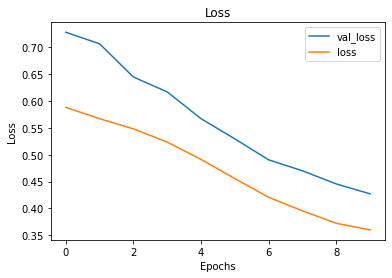

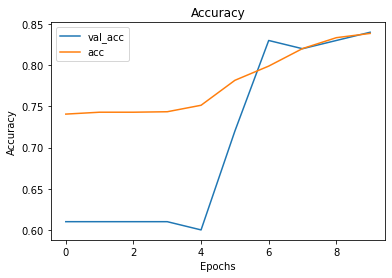

INFO:tensorflow:Assets written to: models/model_7_2\assets


In [19]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=.00001),
              metrics=['acc'])
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=10)
get_report(model)
visualize_training_results(history)
model.save('models/model_7_2')
winsound.Beep(freq, duration)

This random shifts seems to be improving the testing accuracy.

model_7_3:
* Add brightness range to randomly shift brightnesses
* Train over 20 epochs up from 10

Found 5216 images belonging to 2 classes.
Epoch 1/20
105/105 [==============================] - 70s 659ms/step - loss: 0.5814 - acc: 0.7289 - val_loss: 0.7071 - val_acc: 0.6100
Epoch 2/20
105/105 [==============================] - 77s 734ms/step - loss: 0.5493 - acc: 0.7429 - val_loss: 0.7075 - val_acc: 0.6100
Epoch 3/20
105/105 [==============================] - 66s 623ms/step - loss: 0.5204 - acc: 0.7433 - val_loss: 0.6532 - val_acc: 0.6100
Epoch 4/20
105/105 [==============================] - 66s 624ms/step - loss: 0.4833 - acc: 0.7504 - val_loss: 0.6153 - val_acc: 0.6100
Epoch 5/20
105/105 [==============================] - 98s 940ms/step - loss: 0.4518 - acc: 0.7747 - val_loss: 0.5265 - val_acc: 0.8000
Epoch 6/20
105/105 [==============================] - 124s 1s/step - loss: 0.4210 - acc: 0.8014 - val_loss: 0.5328 - val_acc: 0.6600
Epoch 7/20
105/105 [==============================] - 120s 1s/step - loss: 0.3944 - acc: 0.8171 - val_loss: 0.5024 - val_acc: 0.7400
Epoch 8/20
105/10

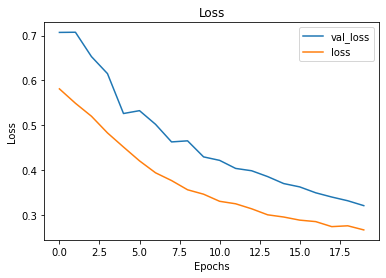

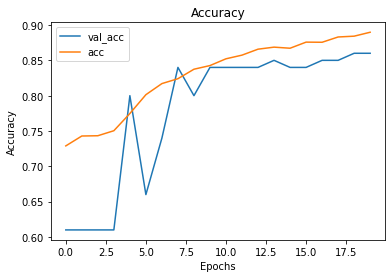

INFO:tensorflow:Assets written to: models/model_7_3\assets


In [20]:
train_gen = ImageDataGenerator(rescale=1./255,
                              rotation_range=15, 
                               fill_mode='nearest',
                               width_shift_range=.1,
                               height_shift_range=.2,
                               brightness_range= [.8,1.2]
                              ).flow_from_directory(
        data_train,
        target_size=(128, 128),
        color_mode='grayscale',
        batch_size=50,
        class_mode='binary')

model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=.00001),
              metrics=['acc'])
history = model.fit(train_gen,
                        validation_data=val_gen,
                        epochs=20)
get_report(model)
visualize_training_results(history)
model.save('models/model_7_3')
winsound.Beep(freq, duration)

In [21]:
train_results_7_3 = model_7_3.evaluate(train_gen)
test_results_7_3 = model_7_3.evaluate(test_gen)
print('Train results_7_3:', train_results_7_3)
print('Test results_7_3:', test_results_7_3)

NameError: name 'model_7_3' is not defined

Test accuracy seems to improve up to about 13 epochs then levels off.

model_7_4:
* add l2 regularization

Epoch 1/20
105/105 [==============================] - 98s 939ms/step - loss: 0.9011 - acc: 0.7412 - val_loss: 1.0532 - val_acc: 0.6100
Epoch 2/20
105/105 [==============================] - 81s 772ms/step - loss: 0.8564 - acc: 0.7429 - val_loss: 0.9764 - val_acc: 0.6100
Epoch 3/20
105/105 [==============================] - 85s 811ms/step - loss: 0.8166 - acc: 0.7452 - val_loss: 0.9229 - val_acc: 0.6300
Epoch 4/20
105/105 [==============================] - 92s 877ms/step - loss: 0.7775 - acc: 0.7569 - val_loss: 0.8400 - val_acc: 0.7000
Epoch 5/20
105/105 [==============================] - 133s 1s/step - loss: 0.7315 - acc: 0.7824 - val_loss: 0.8026 - val_acc: 0.7800
Epoch 6/20
105/105 [==============================] - 107s 1s/step - loss: 0.6970 - acc: 0.8133 - val_loss: 0.7763 - val_acc: 0.7800
Epoch 7/20
105/105 [==============================] - 117s 1s/step - loss: 0.6673 - acc: 0.8275 - val_loss: 0.7428 - val_acc: 0.8100
Epoch 8/20
105/105 [==============================] - 108s 1s

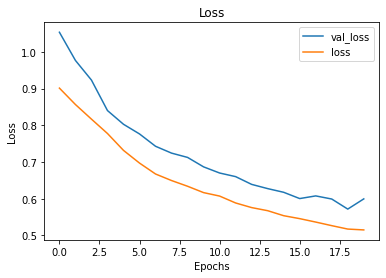

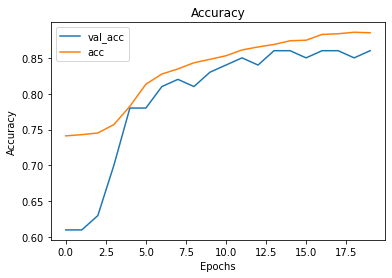

INFO:tensorflow:Assets written to: models/model_7_4\assets


In [22]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 128, 1),
                            kernel_regularizer=regularizers.l2(0.005)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', input_shape=(128, 128, 1),
                            kernel_regularizer=regularizers.l2(0.005)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', input_shape=(128, 128, 1),
                            kernel_regularizer=regularizers.l2(0.005)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=.00001),
              metrics=['acc'])
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=20)
get_report(model)
visualize_training_results(history)
model.save('models/model_7_4')
winsound.Beep(freq, duration)

Model seems to be creeping slowly towards a plateau but never quite reaches peak accuracy.

model_7_4:
* replace l2 with l1 regularization

Epoch 1/20
105/105 [==============================] - 117s 1s/step - loss: 5.7700 - acc: 0.7429 - val_loss: 5.8772 - val_acc: 0.6100
Epoch 2/20
105/105 [==============================] - 108s 1s/step - loss: 5.6354 - acc: 0.7429 - val_loss: 5.7008 - val_acc: 0.6100
Epoch 3/20
105/105 [==============================] - 108s 1s/step - loss: 5.5133 - acc: 0.7429 - val_loss: 5.5927 - val_acc: 0.6100
Epoch 4/20
105/105 [==============================] - 108s 1s/step - loss: 5.3895 - acc: 0.7429 - val_loss: 5.4559 - val_acc: 0.6100
Epoch 5/20
105/105 [==============================] - 105s 1000ms/step - loss: 5.2656 - acc: 0.7433 - val_loss: 5.3484 - val_acc: 0.6100
Epoch 6/20
105/105 [==============================] - 137s 1s/step - loss: 5.1461 - acc: 0.7452 - val_loss: 5.1960 - val_acc: 0.6000
Epoch 7/20
105/105 [==============================] - 118s 1s/step - loss: 5.0312 - acc: 0.7540 - val_loss: 5.0729 - val_acc: 0.6000
Epoch 8/20
105/105 [==============================] - 105s 1s/ste

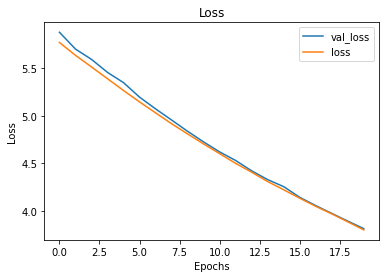

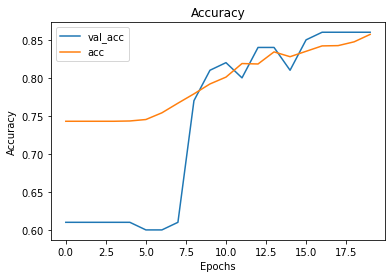

INFO:tensorflow:Assets written to: models/model_7_5\assets


In [23]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 128, 1),
                            kernel_regularizer=regularizers.l1(0.005)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', input_shape=(128, 128, 1),
                            kernel_regularizer=regularizers.l1(0.005)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', input_shape=(128, 128, 1),
                            kernel_regularizer=regularizers.l1(0.005)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=.00001),
              metrics=['acc'])
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=20)
get_report(model)
visualize_training_results(history)
model.save('models/model_7_5')
winsound.Beep(freq, duration)

Validation accuracy seems to have increased slightly.

model_7_6:
* Increase the number of epochs to 40

In [79]:
'''from keras.callbacks import EarlyStopping, ModelCheckpoint'''

In [81]:
'''early_stopping = [EarlyStopping(monitor='val_loss', patience=3),
                  ModelCheckpoint(filepath='/checkpoints', monitor='val_loss',
                                  save_best_only=True)]'''

Epoch 1/40
105/105 [==============================] - 105s 994ms/step - loss: 5.7691 - acc: 0.7433 - val_loss: 5.8434 - val_acc: 0.6100
Epoch 2/40
105/105 [==============================] - 123s 1s/step - loss: 5.6334 - acc: 0.7429 - val_loss: 5.7011 - val_acc: 0.6100
Epoch 3/40
105/105 [==============================] - 104s 994ms/step - loss: 5.5058 - acc: 0.7429 - val_loss: 5.5764 - val_acc: 0.6100
Epoch 4/40
105/105 [==============================] - 121s 1s/step - loss: 5.3807 - acc: 0.7429 - val_loss: 5.4437 - val_acc: 0.6100
Epoch 5/40
105/105 [==============================] - 100s 953ms/step - loss: 5.2553 - acc: 0.7464 - val_loss: 5.3099 - val_acc: 0.6100
Epoch 6/40
105/105 [==============================] - 112s 1s/step - loss: 5.1374 - acc: 0.7590 - val_loss: 5.1860 - val_acc: 0.6000
Epoch 7/40
105/105 [==============================] - 115s 1s/step - loss: 5.0239 - acc: 0.7719 - val_loss: 5.0683 - val_acc: 0.6400
Epoch 8/40
105/105 [==============================] - 109s 1

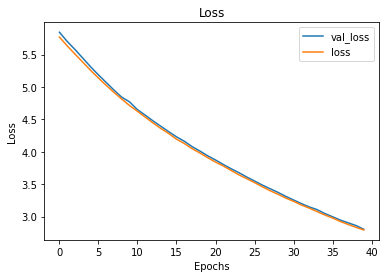

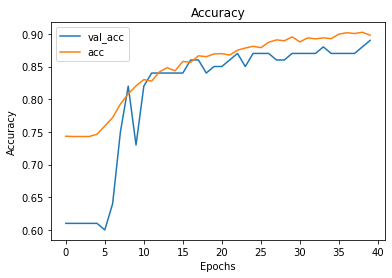

INFO:tensorflow:Assets written to: models/model_7_6\assets


In [24]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 128, 1),
                            kernel_regularizer=regularizers.l1(0.005)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', input_shape=(128, 128, 1),
                            kernel_regularizer=regularizers.l1(0.005)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', input_shape=(128, 128, 1),
                            kernel_regularizer=regularizers.l1(0.005)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=.00001),
              metrics=['acc'])
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=40)
get_report(model)
visualize_training_results(history)
model.save('models/model_7_6')
winsound.Beep(freq, duration)

In [94]:
train_results_7_6 = model_7_6.evaluate(train_gen)
test_results_7_6 = model_7_6.evaluate(test_gen)
print('Train results_7_6:', train_results_7_6)
print('Test results_7_6:', test_results_7_6)

Train results_7_6: [2.483099937438965, 0.8937883377075195]
Test results_7_6: [2.5782666206359863, 0.8425925970077515]


Test accuraucy plateaus around 84.3%. Now lets try using higher resolution images which will increase the number of trainable parameters in the neural network

model_7_7:
* increase image size to (256, 256)

In [25]:
train_gen = ImageDataGenerator(rescale=1./255,
                              rotation_range=15, 
                               fill_mode='nearest',
                               width_shift_range=.1,
                               height_shift_range=.2,
                               brightness_range= [.8,1.2]
                              ).flow_from_directory(
        data_train,
        target_size=(256, 256),
        color_mode='grayscale',
        batch_size=50,
        class_mode='binary')

# get all the data in the directory split/validation (200 images), and reshape them
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_test,
        target_size=(256, 256),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary') 

# get all the data in the directory split/train (542 images), and reshape them
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_val,
        target_size=(256, 256),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary') 

Found 5216 images belonging to 2 classes.
Found 540 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


              precision    recall  f1-score   support

      normal       0.39      0.29      0.33       203
   pneumonia       0.63      0.73      0.68       337

    accuracy                           0.56       540
   macro avg       0.51      0.51      0.50       540
weighted avg       0.54      0.56      0.55       540



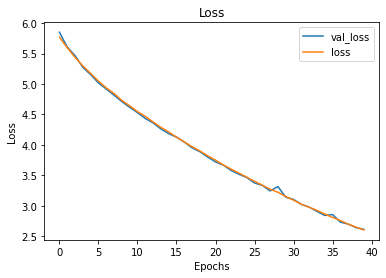

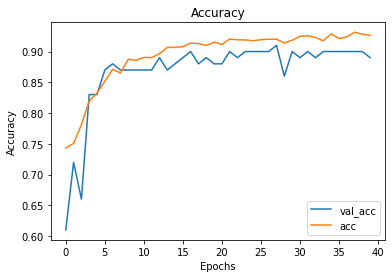

INFO:tensorflow:Assets written to: models/model_7_7\assets


In [27]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(256, 256, 1),
                            kernel_regularizer=regularizers.l1(0.005)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu',
                            kernel_regularizer=regularizers.l1(0.005)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', 
                            kernel_regularizer=regularizers.l1(0.005)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=.00001),
              metrics=['acc'])
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=40)
get_report(model)
visualize_training_results(history)
model.save('models/model_7_7')
winsound.Beep(freq, duration)

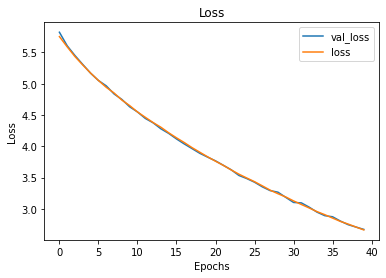

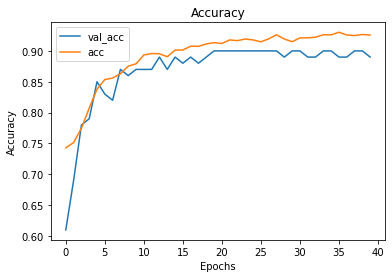

27/27 [==============================] - 10s 391ms/step - loss: 2.8064 - acc: 0.8593
Train results_7_7: [2.6363983154296875, 0.9259969592094421]
Test results_7_7: [2.8063974380493164, 0.8592592477798462]


In [53]:
visualize_training_results(history_7_7)

train_results_7_7 = model_7_7.evaluate(train_gen)
test_results_7_7 = model_7_7.evaluate(test_gen)
print('Train results_7_7:', train_results_7_7)
print('Test results_7_7:', test_results_7_7)

winsound.Beep(freq, duration)

In [97]:
print('Train results_7_7:', train_results_7_7)
print('Test results_7_7:', test_results_7_7)

Train results_7_7: [2.487989664077759, 0.9313650131225586]
Test results_7_7: [2.617629289627075, 0.864814817905426]


In [28]:
metrics.

NameError: name 'model_7_7' is not defined

Test accuracy improved some 2%

model_8:
* Change last dense layer from 512 to 256 nodes
* Decrease number of epochs from 40 to 20

              precision    recall  f1-score   support

      normal       0.39      0.32      0.35       203
   pneumonia       0.63      0.69      0.66       337

    accuracy                           0.55       540
   macro avg       0.51      0.51      0.51       540
weighted avg       0.54      0.55      0.54       540



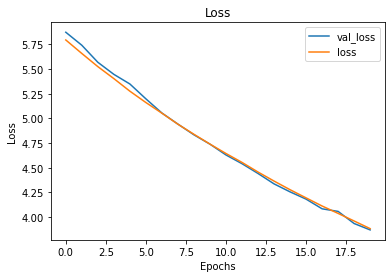

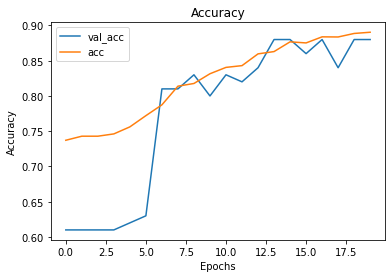

INFO:tensorflow:Assets written to: models/model_8\assets


In [30]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(256, 256, 1),
                            kernel_regularizer=regularizers.l1(0.005)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu',
                            kernel_regularizer=regularizers.l1(0.005)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', 
                            kernel_regularizer=regularizers.l1(0.005)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=.00001),
              metrics=['acc'])
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=20)
get_report(model)
visualize_training_results(history)
model.save('models/model_8')
winsound.Beep(freq, duration)

Test accuracy decreased about a percent.

Build a model from Xception pre-trained model keras

In [ ]:
train_gen = ImageDataGenerator(rescale=1./255,
                               rotation_range=15, 
                               fill_mode='nearest',
                               width_shift_range=.1,
                               height_shift_range=.2,
                               brightness_range= [.8,1.2]
                              ).flow_from_directory(
        data_train,
        target_size=(256, 256),
        color_mode='rgb',
        batch_size=50,
        class_mode='binary') 
# get all the data in the directory split/validation (200 images), and reshape them
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_test,
        target_size=(256, 256),
        color_mode='rgb',
        batch_size=20,
        class_mode='binary') 

# get all the data in the directory split/train (542 images), and reshape them
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_val,
        target_size=(256, 256),
        color_mode='rgb',
        batch_size=20,
        class_mode='binary') 

In [9]:
Xception_base = Xception(weights='imagenet',
                 include_top=False,
                 input_shape=(256, 256, 3))

83697664/83683744 [==============================] - 9s 0us/step


In [ ]:
# Define Model Architecture
model = models.Sequential()
model.add(Xception_base)
model.add(layers.Flatten())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Xception_base.trainable = False

In [ ]:
model.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=.00001),
              metrics=['acc'])
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=20)
get_report(model)
visualize_training_results(history)
model.save('models/model_9')
winsound.Beep(freq, duration)

In [ ]:
model.save('models/model_9')

Dynamic Histogram Enhancement - Image enhancement

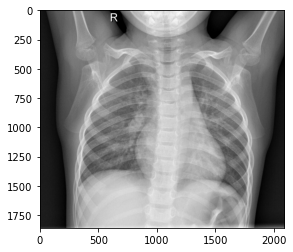

In [17]:
image = PIL.Image.open("IM-0115-0001.jpeg")
plt.imshow(image, cmap='gray')

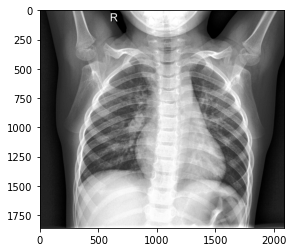

In [21]:
src = cv.imread("IM-0115-0001.jpeg")
src = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
equ = cv.equalizeHist(src, cv.COLOR_BGR2GRAY)
image = PIL.Image.fromarray(equ)
plt.imshow(image, cmap='gray')

In [35]:
# Create list of paths to each folder of data
paths = ['chest_xray/train/normal', 'chest_xray/train/pneumonia', 'chest_xray/test/normal', 
         'chest_xray/test/pneumonia', 'chest_xray/val/normal', 'chest_xray/val/pneumonia']
# For each folder
for path in paths:
    
    # Create a corresponding folder for the enhanced images
    enhanced = 'enhanced{}'.format(path[10:])
    os.makedirs(enhanced)
    
    # Get the file names for each image in the current path
    data = [file for file in os.listdir(path=path) if file.endswith('jpeg')]
    
    # For each image in the current folder, enhance it and add it to the corresponding enhanced folder
    for xray in data:
        src = cv.imread('{}/{}'.format(path, xray))
        src = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
        equ = cv.equalizeHist(src, cv.COLOR_BGR2GRAY)
        im = PIL.Image.fromarray(equ)
        im.save(enhanced+'/'+xray)   
        

In [37]:
# Create paths to new enhanced data folders
enhanced_train = 'enhanced/train'
enhanced_test = 'enhanced/test'
enhanced_val = 'enhanced/val'

Establish new ImageDataGenerator's to feed in the new enhanced data.

In [38]:
train_gen = ImageDataGenerator(rescale=1./255,
                              rotation_range=15, 
                               fill_mode='nearest',
                               width_shift_range=.1,
                               height_shift_range=.2,
                               brightness_range= [.8,1.2]
                              ).flow_from_directory(
        enhanced_train,
        target_size=(256, 256),
        color_mode='grayscale',
        batch_size=50,
        class_mode='binary'
) 
# get all the data in the directory split/validation (200 images), and reshape them
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        enhanced_test,
        target_size=(256, 256),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary') 

# get all the data in the directory split/train (542 images), and reshape them
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        enhanced_val,
        target_size=(256, 256),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary') 

Found 5216 images belonging to 2 classes.
Found 540 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


Run the best model (model_7_7) on the new enhanced data.

In [42]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(256, 256, 1),
                            kernel_regularizer=regularizers.l1(0.005)))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(32, (3,3,), activation='relu',
                            kernel_regularizer=regularizers.l1(0.005)))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64, (3,3,), activation='relu', 
                            kernel_regularizer=regularizers.l1(0.005)))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=.00001),
              metrics=['acc'])
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=30)
get_report(model)
visualize_training_results(history)
model.save('models/model_7_7_1')
winsound.Beep(freq, duration)

Epoch 1/30
105/105 [==============================] - 187s 2s/step - loss: 5.7604 - acc: 0.7375 - val_loss: 5.7587 - val_acc: 0.6100
Epoch 2/30
105/105 [==============================] - 158s 2s/step - loss: 5.6059 - acc: 0.7431 - val_loss: 5.5796 - val_acc: 0.6200
Epoch 3/30
105/105 [==============================] - 149s 1s/step - loss: 5.4547 - acc: 0.7609 - val_loss: 5.4202 - val_acc: 0.6400
Epoch 4/30
105/105 [==============================] - 170s 2s/step - loss: 5.3143 - acc: 0.7933 - val_loss: 5.2689 - val_acc: 0.7800
Epoch 5/30
105/105 [==============================] - 163s 2s/step - loss: 5.1841 - acc: 0.8110 - val_loss: 5.1542 - val_acc: 0.7800
Epoch 6/30
105/105 [==============================] - 167s 2s/step - loss: 5.0626 - acc: 0.8303 - val_loss: 4.9876 - val_acc: 0.8800
Epoch 7/30
105/105 [==============================] - 148s 1s/step - loss: 4.9531 - acc: 0.8503 - val_loss: 4.9140 - val_acc: 0.8500
Epoch 8/30
105/105 [==============================] - 161s 2s/step - 

NameError: name 'visualize_training_results' is not defined

Image Size: 2090 x 1858


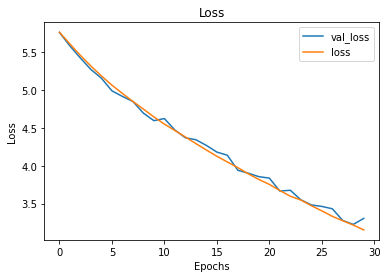

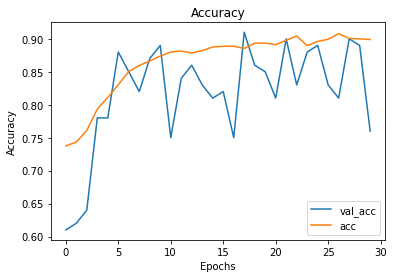

In [46]:
visualize_training_results(history_7_7_1)

In [47]:
model_7_7_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 254, 254, 16)      160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 57600)            

In [58]:
train_gen = ImageDataGenerator(rescale=1./255,
                              rotation_range=15, 
                               fill_mode='nearest',
                               width_shift_range=.1,
                               height_shift_range=.2,
                               brightness_range= [.8,1.2]
                              ).flow_from_directory(
        data_train,
        target_size=(500,500),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary'
) 
# get all the data in the directory split/validation (200 images), and reshape them
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_test,
        target_size=(500,500),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary') 

# get all the data in the directory split/train (542 images), and reshape them
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_val,
        target_size=(500,500),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary') 

Found 5216 images belonging to 2 classes.
Found 540 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [57]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(500,500, 1),
                            kernel_regularizer=regularizers.l1(0.005)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu',
                            kernel_regularizer=regularizers.l1(0.005)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', 
                            kernel_regularizer=regularizers.l1(0.005)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', 
                            kernel_regularizer=regularizers.l1(0.005)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=.00001),
              metrics=['acc'])
history = model.fit(train_gen,
                        validation_data=val_gen,
                        epochs=30)
get_report(model)
visualize_training_results(history)
model.save('models/model_10')
winsound.Beep(freq, duration)

Epoch 1/30
  3/261 [..............................] - ETA: 5:31 - loss: 12.6365 - acc: 0.6833

KeyboardInterrupt: 

In [52]:
model_10.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 498, 498, 16)      160       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 249, 249, 16)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 247, 247, 32)      4640      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 123, 123, 32)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 121, 121, 64)      18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 60, 60, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 58, 58, 64)       

In [124]:
model = keras.models.load_model('models/model_7_7')

In [60]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)            

In [96]:
train_gen = ImageDataGenerator(rescale=1./255,
                              rotation_range=15, 
                               fill_mode='nearest',
                               width_shift_range=.1,
                               height_shift_range=.2,
                               brightness_range= [.8,1.2]
                              ).flow_from_directory(
        data_train,
        target_size=(256, 256),
        color_mode='grayscale',
        batch_size=50,
        class_mode='binary'
) 
# get all the data in the directory split/validation (200 images), and reshape them
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_test,
        target_size=(256, 256),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary') 

# get all the data in the directory split/train (542 images), and reshape them
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_val,
        target_size=(256, 256),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary') 

Found 5216 images belonging to 2 classes.
Found 540 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [34]:
# get all the data in the directory split/test, and reshape them
train_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_train,
        target_size=(500,500),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary') 

# get all the data in the directory split/validation (200 images), and reshape them
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_test,
        target_size=(500,500),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary') 

# get all the data in the directory split/train (542 images), and reshape them
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_val,
        target_size=(500,500),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary') 

Found 5216 images belonging to 2 classes.
Found 540 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


Epoch 1/10
261/261 [==============================] - 610s 2s/step - loss: 2.2660 - acc: 0.9062 - val_loss: 1.2004 - val_acc: 0.6700
Epoch 2/10
261/261 [==============================] - 530s 2s/step - loss: 0.1072 - acc: 0.9582 - val_loss: 0.5717 - val_acc: 0.7800
Epoch 3/10
261/261 [==============================] - 557s 2s/step - loss: 0.0544 - acc: 0.9804 - val_loss: 1.0317 - val_acc: 0.6600
Epoch 4/10
261/261 [==============================] - 519s 2s/step - loss: 0.0246 - acc: 0.9933 - val_loss: 1.6168 - val_acc: 0.6800
Epoch 5/10
261/261 [==============================] - 499s 2s/step - loss: 0.0155 - acc: 0.9965 - val_loss: 1.1453 - val_acc: 0.7100
Epoch 6/10
261/261 [==============================] - 513s 2s/step - loss: 0.0063 - acc: 0.9994 - val_loss: 0.8796 - val_acc: 0.7600
Epoch 7/10
261/261 [==============================] - 458s 2s/step - loss: 0.0041 - acc: 0.9998 - val_loss: 0.9915 - val_acc: 0.7300
Epoch 8/10
261/261 [==============================] - 535s 2s/step - 

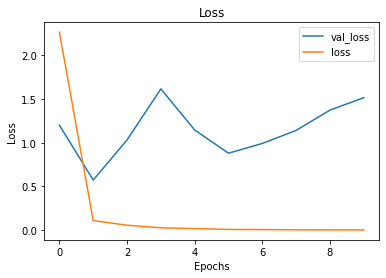

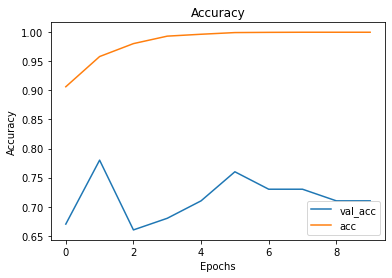

INFO:tensorflow:Assets written to: models/model_11\assets


In [39]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3,), activation='relu', input_shape=(500, 500, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(),
              metrics=['acc'])
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=10)
get_report(model)
visualize_training_results(history)
model.save('models/model_11')
winsound.Beep(freq, duration)

Found 5216 images belonging to 2 classes.
Found 540 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Epoch 1/10
261/261 [==============================] - 63s 239ms/step - loss: 0.2721 - acc: 0.8861 - val_loss: 0.5229 - val_acc: 0.7800
Epoch 2/10
261/261 [==============================] - 74s 283ms/step - loss: 0.1029 - acc: 0.9595 - val_loss: 0.5284 - val_acc: 0.7900
Epoch 3/10
261/261 [==============================] - 71s 272ms/step - loss: 0.0827 - acc: 0.9688 - val_loss: 0.6080 - val_acc: 0.7700
Epoch 4/10
261/261 [==============================] - 63s 243ms/step - loss: 0.0715 - acc: 0.9734 - val_loss: 0.8714 - val_acc: 0.7500
Epoch 5/10
261/261 [==============================] - 57s 218ms/step - loss: 0.0663 - acc: 0.9753 - val_loss: 1.2534 - val_acc: 0.6700
Epoch 6/10
261/261 [==============================] - 57s 217ms/step - loss: 0.0646 - acc: 0.9755 - val_loss: 0.6059 - val_acc: 0.7800
Epoch 7/10
261/261 [==============================] - 68s 262ms/st

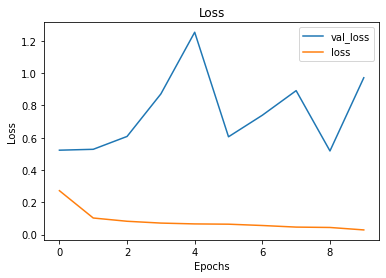

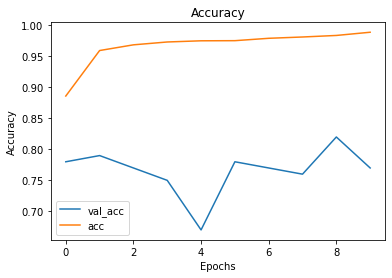

INFO:tensorflow:Assets written to: models/model_12\assets


In [40]:
# get all the data in the directory split/test, and reshape them
train_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_train,
        target_size=(128,128),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary') 

# get all the data in the directory split/validation (200 images), and reshape them
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_test,
        target_size=(128,128),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary') 

# get all the data in the directory split/train (542 images), and reshape them
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_val,
        target_size=(128,128),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary') 

model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(),
              metrics=['acc'])
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=10)
get_report(model)
visualize_training_results(history)
model.save('models/model_12')
winsound.Beep(freq, duration)

In [41]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 126, 126, 16)      160       
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 61, 61, 16)        2320      
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 28, 28, 32)        4640      
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 6272)            

Found 5216 images belonging to 2 classes.
Found 540 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Epoch 1/10
261/261 [==============================] - 185s 705ms/step - loss: 0.4667 - acc: 0.9156 - val_loss: 0.3637 - val_acc: 0.8500
Epoch 2/10
261/261 [==============================] - 213s 815ms/step - loss: 0.0386 - acc: 0.9866 - val_loss: 0.9056 - val_acc: 0.7300
Epoch 3/10
261/261 [==============================] - 226s 867ms/step - loss: 0.0116 - acc: 0.9975 - val_loss: 0.7690 - val_acc: 0.7600
Epoch 4/10
261/261 [==============================] - 229s 878ms/step - loss: 0.0029 - acc: 1.0000 - val_loss: 1.5925 - val_acc: 0.7000
Epoch 5/10
261/261 [==============================] - 204s 780ms/step - loss: 6.9355e-04 - acc: 1.0000 - val_loss: 2.4108 - val_acc: 0.6800
Epoch 6/10
261/261 [==============================] - 222s 851ms/step - loss: 3.9249e-04 - acc: 1.0000 - val_loss: 1.8635 - val_acc: 0.7000
Epoch 7/10
261/261 [==============================] 

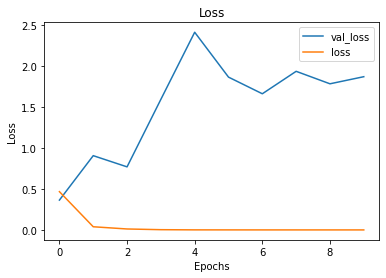

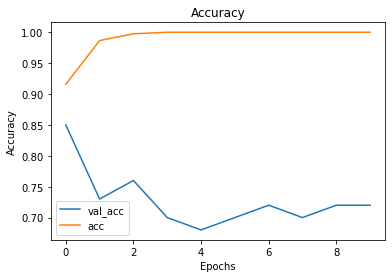

INFO:tensorflow:Assets written to: models/model_13\assets


In [44]:
# get all the data in the directory split/test, and reshape them
train_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_train,
        target_size=(264,264),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary') 

# get all the data in the directory split/validation (200 images), and reshape them
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_test,
        target_size=(264,264),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary') 

# get all the data in the directory split/train (542 images), and reshape them
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_val,
        target_size=(264,264),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary') 

model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(264, 264, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(),
              metrics=['acc'])
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=10)
get_report(model)
visualize_training_results(history)
model.save('models/model_13')
winsound.Beep(freq, duration)

Found 5216 images belonging to 2 classes.
Found 540 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Epoch 1/10
261/261 [==============================] - 83s 314ms/step - loss: 0.4380 - acc: 0.8027 - val_loss: 0.4559 - val_acc: 0.7900
Epoch 2/10
261/261 [==============================] - 51s 197ms/step - loss: 0.2032 - acc: 0.9189 - val_loss: 0.5096 - val_acc: 0.7400
Epoch 3/10
261/261 [==============================] - 54s 206ms/step - loss: 0.1374 - acc: 0.9477 - val_loss: 0.3387 - val_acc: 0.8300
Epoch 4/10
261/261 [==============================] - 52s 198ms/step - loss: 0.1049 - acc: 0.9597 - val_loss: 0.5629 - val_acc: 0.7200
Epoch 5/10
261/261 [==============================] - 48s 184ms/step - loss: 0.0891 - acc: 0.9670 - val_loss: 0.6016 - val_acc: 0.7700
Epoch 6/10
261/261 [==============================] - 53s 204ms/step - loss: 0.0901 - acc: 0.9676 - val_loss: 0.6087 - val_acc: 0.7500
Epoch 7/10
261/261 [==============================] - 65s 250ms/st

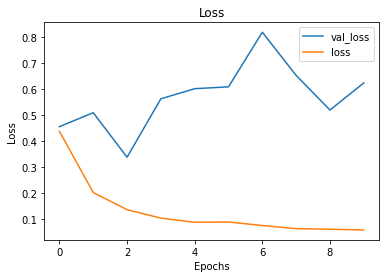

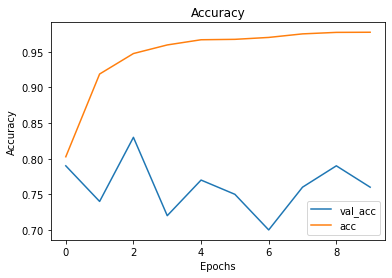

INFO:tensorflow:Assets written to: models/model_14\assets


In [57]:
# get all the data in the directory split/test, and reshape them
train_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_train,
        target_size=(64,64),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary') 

# get all the data in the directory split/validation (200 images), and reshape them
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_test,
        target_size=(64,64),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary') 

# get all the data in the directory split/train (542 images), and reshape them
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_val,
        target_size=(64,64),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary') 

model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(64, 64, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(16, (3,3,), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(),
              metrics=['acc'])
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=10)
get_report(model)
visualize_training_results(history)
model.save('models/model_14')
winsound.Beep(freq, duration)

In [56]:
model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 62, 62, 16)        160       
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 29, 29, 16)        2320      
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 12, 12, 32)        4640      
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 4, 4, 32)        

Found 5216 images belonging to 2 classes.
Found 540 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Epoch 1/10
261/261 [==============================] - 53s 201ms/step - loss: 0.4190 - acc: 0.8075 - val_loss: 0.3058 - val_acc: 0.8700
Epoch 2/10
261/261 [==============================] - 56s 216ms/step - loss: 0.1927 - acc: 0.9243 - val_loss: 0.6574 - val_acc: 0.6800
Epoch 3/10
261/261 [==============================] - 51s 195ms/step - loss: 0.1401 - acc: 0.9465 - val_loss: 0.6162 - val_acc: 0.7500
Epoch 4/10
261/261 [==============================] - 52s 200ms/step - loss: 0.1104 - acc: 0.9576 - val_loss: 0.6708 - val_acc: 0.7300
Epoch 5/10
261/261 [==============================] - 51s 196ms/step - loss: 0.0969 - acc: 0.9628 - val_loss: 0.6819 - val_acc: 0.6800
Epoch 6/10
261/261 [==============================] - 49s 189ms/step - loss: 0.0894 - acc: 0.9664 - val_loss: 0.6943 - val_acc: 0.7400
Epoch 7/10
261/261 [==============================] - 49s 187ms/st

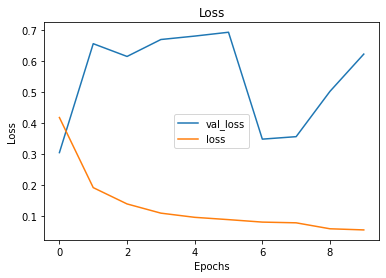

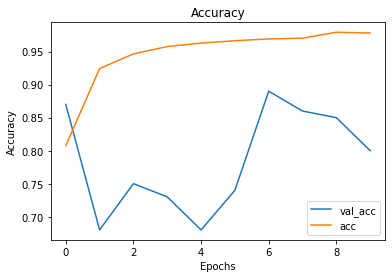

INFO:tensorflow:Assets written to: models/model_15\assets


In [58]:
# get all the data in the directory split/test, and reshape them
train_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_train,
        target_size=(64,56),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary') 

# get all the data in the directory split/validation (200 images), and reshape them
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_test,
        target_size=(64,56),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary') 

# get all the data in the directory split/train (542 images), and reshape them
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_val,
        target_size=(64,56),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary') 

model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(64, 56, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(16, (3,3,), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(),
              metrics=['acc'])
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=10)
get_report(model)
visualize_training_results(history)
model.save('models/model_15')
winsound.Beep(freq, duration)

Found 5216 images belonging to 2 classes.
Found 540 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Epoch 1/10
261/261 [==============================] - 60s 230ms/step - loss: 0.3017 - acc: 0.8681 - val_loss: 1.0017 - val_acc: 0.6700
Epoch 2/10
261/261 [==============================] - 59s 225ms/step - loss: 0.1347 - acc: 0.9467 - val_loss: 0.6130 - val_acc: 0.7300
Epoch 3/10
261/261 [==============================] - 67s 256ms/step - loss: 0.1194 - acc: 0.9536 - val_loss: 0.5966 - val_acc: 0.7300
Epoch 4/10
261/261 [==============================] - 64s 246ms/step - loss: 0.0879 - acc: 0.9668 - val_loss: 0.6860 - val_acc: 0.7400
Epoch 5/10
261/261 [==============================] - 62s 238ms/step - loss: 0.0811 - acc: 0.9701 - val_loss: 0.5232 - val_acc: 0.8100
Epoch 6/10
261/261 [==============================] - 57s 216ms/step - loss: 0.0691 - acc: 0.9747 - val_loss: 0.6636 - val_acc: 0.7200
Epoch 7/10
261/261 [==============================] - 62s 239ms/st

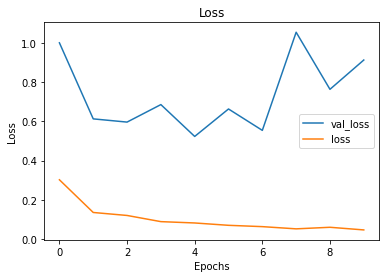

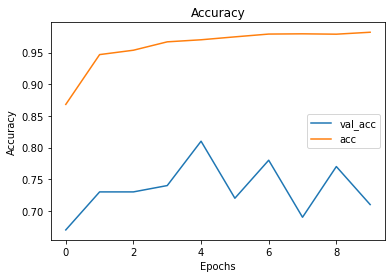

INFO:tensorflow:Assets written to: models/model_16\assets


In [60]:
# get all the data in the directory split/test, and reshape them
train_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_train,
        target_size=(128,114),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary') 

# get all the data in the directory split/validation (200 images), and reshape them
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_test,
        target_size=(128, 114),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary') 

# get all the data in the directory split/train (542 images), and reshape them
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_val,
        target_size=(128, 114),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary') 

model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 114, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(16, (3,3,), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(),
              metrics=['acc'])
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=10)
get_report(model)
visualize_training_results(history)
model.save('models/model_16')
winsound.Beep(freq, duration)

Found 5216 images belonging to 2 classes.
Found 540 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Epoch 1/10
261/261 [==============================] - 60s 226ms/step - loss: 17.8058 - acc: 0.7429 - val_loss: 17.3019 - val_acc: 0.6100
Epoch 2/10
261/261 [==============================] - 59s 227ms/step - loss: 16.7928 - acc: 0.7429 - val_loss: 16.3171 - val_acc: 0.6100
Epoch 3/10
261/261 [==============================] - 77s 297ms/step - loss: 15.8089 - acc: 0.7429 - val_loss: 15.3723 - val_acc: 0.6100
Epoch 4/10
261/261 [==============================] - 74s 285ms/step - loss: 14.8531 - acc: 0.7429 - val_loss: 14.4761 - val_acc: 0.6100
Epoch 5/10
261/261 [==============================] - 62s 236ms/step - loss: 13.9417 - acc: 0.7429 - val_loss: 13.6135 - val_acc: 0.6100
Epoch 6/10
261/261 [==============================] - 61s 233ms/step - loss: 13.0737 - acc: 0.7429 - val_loss: 12.7762 - val_acc: 0.6100
Epoch 7/10
261/261 [==============================] - 

C:\Users\holde\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\holde\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\holde\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


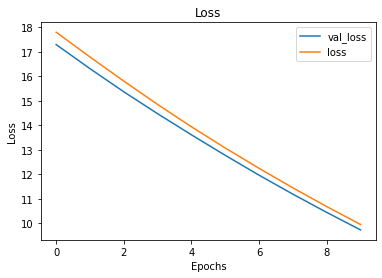

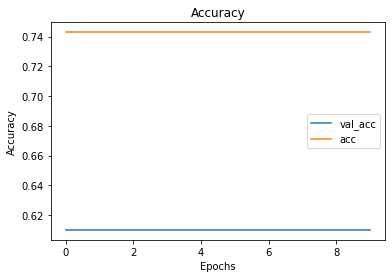

INFO:tensorflow:Assets written to: models/model_17\assets


In [63]:
# get all the data in the directory split/test, and reshape them
train_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_train,
        target_size=(128,114),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary') 

# get all the data in the directory split/validation (200 images), and reshape them
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_test,
        target_size=(128, 114),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary') 

# get all the data in the directory split/train (542 images), and reshape them
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_val,
        target_size=(128, 114),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary') 

model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 114, 1),
                        kernel_regularizer=regularizers.l1(.005)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(16, (3,3,), activation='relu', kernel_regularizer=regularizers.l1(0.005)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', kernel_regularizer=regularizers.l1(0.005)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', kernel_regularizer=regularizers.l1(0.005)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1(0.005)))
model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1(0.005)))
model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l1(0.005)))

model.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=.00001),
              metrics=['acc'])
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=10)
get_report(model)
visualize_training_results(history)
model.save('models/model_17')
winsound.Beep(freq, duration)

Found 5216 images belonging to 2 classes.
Found 540 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Epoch 1/10
261/261 [==============================] - 67s 254ms/step - loss: 0.5742 - acc: 0.7429 - val_loss: 0.6577 - val_acc: 0.6100
Epoch 2/10
261/261 [==============================] - 64s 247ms/step - loss: 0.3957 - acc: 0.8194 - val_loss: 0.2529 - val_acc: 0.8800
Epoch 3/10
261/261 [==============================] - 81s 312ms/step - loss: 0.2031 - acc: 0.9156 - val_loss: 0.2544 - val_acc: 0.8900
Epoch 4/10
261/261 [==============================] - 67s 255ms/step - loss: 0.1707 - acc: 0.9319 - val_loss: 0.3891 - val_acc: 0.8100
Epoch 5/10
261/261 [==============================] - 63s 241ms/step - loss: 0.1446 - acc: 0.9434 - val_loss: 0.3241 - val_acc: 0.8700
Epoch 6/10
261/261 [==============================] - 57s 219ms/step - loss: 0.1330 - acc: 0.9484 - val_loss: 0.5230 - val_acc: 0.7600
Epoch 7/10
261/261 [==============================] - 81s 310ms/st

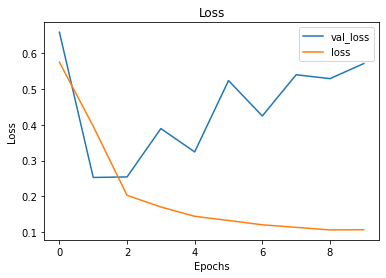

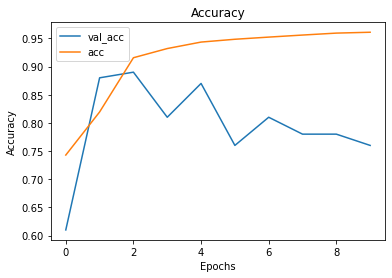

INFO:tensorflow:Assets written to: models/model_18\assets


In [68]:
# get all the data in the directory split/test, and reshape them
train_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_train,
        target_size=(128,114),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary') 

# get all the data in the directory split/validation (200 images), and reshape them
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_test,
        target_size=(128, 114),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary') 

# get all the data in the directory split/train (542 images), and reshape them
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_val,
        target_size=(128, 114),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary') 

model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 114, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(16, (3,3,), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=.0001),
              metrics=['acc'])
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=10)
get_report(model)
visualize_training_results(history)
model.save('models/model_18')
winsound.Beep(freq, duration)

Found 5216 images belonging to 2 classes.
Found 540 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Epoch 1/10
261/261 [==============================] - 98s 373ms/step - loss: 0.3090 - acc: 0.8735 - val_loss: 0.5941 - val_acc: 0.7600
Epoch 2/10
261/261 [==============================] - 113s 433ms/step - loss: 0.1184 - acc: 0.9572 - val_loss: 0.9062 - val_acc: 0.7100
Epoch 3/10
261/261 [==============================] - 112s 429ms/step - loss: 0.0795 - acc: 0.9722 - val_loss: 0.2096 - val_acc: 0.9200
Epoch 4/10
261/261 [==============================] - 117s 449ms/step - loss: 0.0693 - acc: 0.9732 - val_loss: 1.0314 - val_acc: 0.6900
Epoch 5/10
261/261 [==============================] - 116s 446ms/step - loss: 0.0679 - acc: 0.9735 - val_loss: 0.5306 - val_acc: 0.7900
Epoch 6/10
261/261 [==============================] - 119s 455ms/step - loss: 0.0461 - acc: 0.9856 - val_loss: 1.0599 - val_acc: 0.7000
Epoch 7/10
261/261 [==============================] - 111s 42

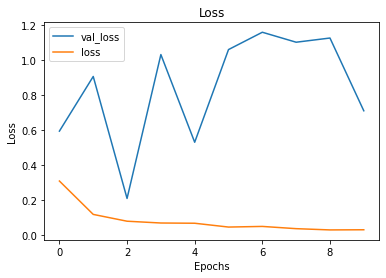

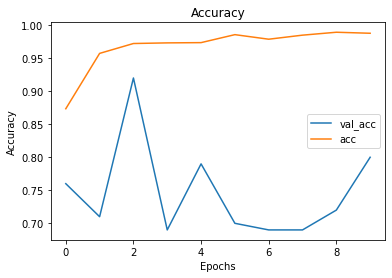

INFO:tensorflow:Assets written to: models/model_19\assets


In [69]:
# get all the data in the directory split/test, and reshape them
train_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_train,
        target_size=(256, 227),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary') 

# get all the data in the directory split/validation (200 images), and reshape them
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_test,
        target_size=(256, 227),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary') 

# get all the data in the directory split/train (542 images), and reshape them
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_val,
        target_size=(256, 227),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary') 

model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(256, 227, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(16, (3,3,), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(),
              metrics=['acc'])
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=10)
get_report(model)
visualize_training_results(history)
model.save('models/model_19')
winsound.Beep(freq, duration)

In [62]:
# get all the data in the directory split/test, and reshape them
train_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_train,
        target_size=(256, 227),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary') 

# get all the data in the directory split/validation (200 images), and reshape them
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_test,
        target_size=(256, 227),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary',
        shuffle=False) 

# get all the data in the directory split/train (542 images), and reshape them
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_val,
        target_size=(256, 227),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary') 

model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(256, 227, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(16, (3,3,), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1(.005)))
model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1(.005)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(),
              metrics=['acc'])
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=10)
get_report(model)
visualize_training_results(history)
model.save('models/model_20')
winsound.Beep(freq, duration)

Found 5216 images belonging to 2 classes.
Found 540 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Epoch 1/10
261/261 [==============================] - 224s 855ms/step - loss: 2.6612 - acc: 0.7812 - val_loss: 1.1501 - val_acc: 0.6700
Epoch 2/10
261/261 [==============================] - 166s 634ms/step - loss: 0.5055 - acc: 0.9279 - val_loss: 0.7586 - val_acc: 0.8100
Epoch 3/10
261/261 [==============================] - 146s 558ms/step - loss: 0.4370 - acc: 0.9436 - val_loss: 0.5777 - val_acc: 0.8700
Epoch 4/10
261/261 [==============================] - 153s 586ms/step - loss: 0.4170 - acc: 0.9500 - val_loss: 0.5634 - val_acc: 0.8800
Epoch 5/10
261/261 [==============================] - 146s 558ms/step - loss: 0.3874 - acc: 0.9561 - val_loss: 0.6978 - val_acc: 0.8600
Epoch 6/10
261/261 [==============================] - 147s 561ms/step - loss: 0.3740 - acc: 0.9572 - val_loss: 0.9636 - val_acc: 0.7600
Epoch 7/10
261/261 [==============================] - 636s 2

NameError: name 'get_report' is not defined

In [42]:
from sklearn.metrics import accuracy_score
import pandas as pd

In [12]:
# get all the data in the directory split/train (542 images), and reshape them
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_val,
        target_size=(256, 227),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary') 

Found 100 images belonging to 2 classes.


In [57]:
# get all the data in the directory split/validation (200 images), and reshape them
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_test,
        target_size=(256, 227),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary',
        shuffle=False) 

Found 540 images belonging to 2 classes.


In [6]:
model = keras.models.load_model('models/model_20')

In [65]:
results = []
for i in range(5):
    preds = model.predict(val_gen)
    preds[preds>=.5]=1
    preds[preds<.5]=0
    results.append(accuracy_score(val_gen.labels, preds))

In [66]:
sum(results) / len(results)

0.5760000000000001

In [68]:
results

[0.56, 0.62, 0.56, 0.58, 0.56]

In [71]:
accuracy_score(val_gen.labels, preds)

0.56

In [39]:
x = preds

In [45]:
y = preds
z = pd.DataFrame(data=x)

In [47]:
z['1'] = y

In [49]:
z

,0,1
0,0.0,1.0
1,0.0,1.0
2,1.0,1.0
3,0.0,0.0
4,1.0,1.0
...,...,...
95,1.0,1.0
96,1.0,1.0
97,1.0,1.0
98,0.0,1.0


In [34]:
val_gen.labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [37]:
val_gen.labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [72]:
# get all the data in the directory split/test, and reshape them
train_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_train,
        target_size=(256, 227),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary') 

# get all the data in the directory split/validation (200 images), and reshape them
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_test,
        target_size=(256, 227),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary') 

# get all the data in the directory split/train (542 images), and reshape them
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_val,
        target_size=(256, 227),
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary') 

model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(256, 227, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(16, (3,3,), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1(.005)))
model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1(.005)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=.0001),
              metrics=['acc'])
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=10)
get_report(model)
visualize_training_results(history)
model.save('models/model_21')
winsound.Beep(freq, duration)

Found 5216 images belonging to 2 classes.
Found 540 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Epoch 1/10
214/261 [=======================>......] - ETA: 20s - loss: 16.0959 - acc: 0.7320

KeyboardInterrupt: 